In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')


FILEPATH = "/content/drive/MyDrive/AAPL.csv"
aapl_data = pd.read_csv(FILEPATH, index_col=0, parse_dates=True)
returns_aapl = aapl_data['Adj_Close'].pct_change().dropna().rename('Rets')
returns_aapl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Rets
Date,
2010-01-05 00:00:00+00:00,0.001729
2010-01-06 00:00:00+00:00,-0.015906
2010-01-07 00:00:00+00:00,-0.001849
2010-01-08 00:00:00+00:00,0.006648
2010-01-11 00:00:00+00:00,-0.008821
...,...
2020-12-23 00:00:00+00:00,-0.006976
2020-12-24 00:00:00+00:00,0.007712
2020-12-28 00:00:00+00:00,0.035766


In [13]:
FILEPATH_amzn = "/content/drive/MyDrive/AMZN.csv"
amzn_data = pd.read_csv(FILEPATH_amzn, index_col=0, parse_dates=True, skiprows=[1, 2])
# Convert 'Adj_Close' to numeric, ensuring non-numeric values are handled
amzn_data['Adj_Close'] = pd.to_numeric(amzn_data['Adj_Close'], errors='coerce')
# Calculate daily returns and drop any NA values that result
returns_amzn = amzn_data['Adj_Close'].pct_change().dropna().rename('Rets')
returns_amzn.index = returns_amzn.index.rename('Date')
returns_amzn


,Rets
Date,
2010-01-05 00:00:00+00:00,0.005900
2010-01-06 00:00:00+00:00,-0.018116
2010-01-07 00:00:00+00:00,-0.017013
2010-01-08 00:00:00+00:00,0.027077
2010-01-11 00:00:00+00:00,-0.024041
...,...
2020-12-23 00:00:00+00:00,-0.006627
2020-12-24 00:00:00+00:00,-0.003949
2020-12-28 00:00:00+00:00,0.035071


# **Farinelli-Tibiletti (F–T) Ratio**

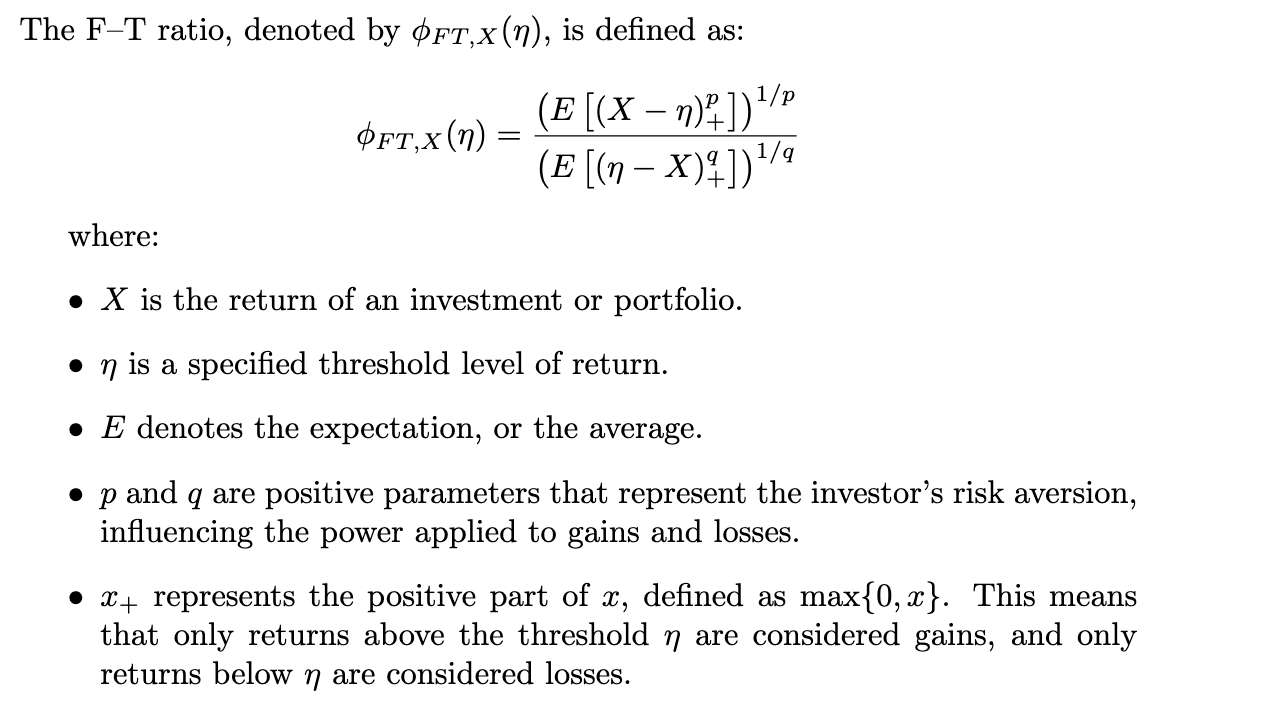

In [4]:
def empirical_ft_ratio(returns, eta, p, q):
    # Calculate positive gains and losses from the threshold
    gains = np.maximum(0, returns - eta)
    losses = np.maximum(0, eta - returns)

    # Raise gains and losses to the powers p and q respectively
    gains_p = gains**p
    losses_q = losses**q

    # Calculate the means of these raised values
    mean_gains_p = np.mean(gains_p)
    mean_losses_q = np.mean(losses_q)

    # Take the p-th and q-th roots and compute the ratio
    if mean_losses_q > 0:  # To avoid division by zero
        ft_ratio = (mean_gains_p ** (1/p)) / (mean_losses_q ** (1/q))
    else:
        ft_ratio = np.nan  # Assign NaN if losses mean is zero to avoid division by zero

    return ft_ratio

eta = np.quantile(returns_aapl, 0.5)  # Use median as the threshold
p = 2
q = 2
result = empirical_ft_ratio(returns_aapl, eta, p, q)
print("Empirical FT Ratio:", result)

Empirical FT Ratio: 1.0079098578112975


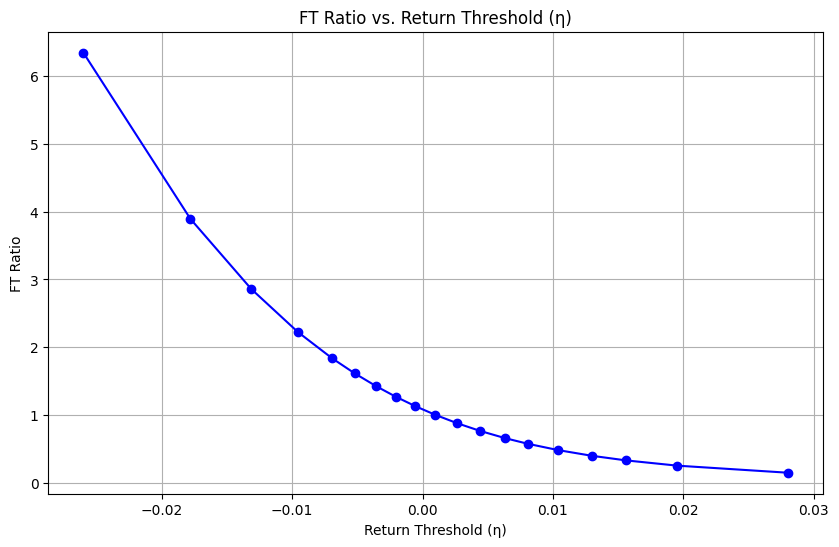

In [5]:
etas = np.quantile(returns_aapl, np.linspace(0.05, 0.95, 19))  # Quantiles from 5% to 95%
ft_ratios = [empirical_ft_ratio(returns_aapl, eta, p=2, q=2) for eta in etas]

plt.figure(figsize=(10, 6))
plt.plot(etas, ft_ratios, marker='o', linestyle='-', color='blue')
plt.title('FT Ratio vs. Return Threshold (η)')
plt.xlabel('Return Threshold (η)')
plt.ylabel('FT Ratio')
plt.grid(True)
plt.show()

observation:
1. The F–T ratio starts very high when the return threshold 𝜂 is set below zero. This suggests that there are few losses exceeding this low threshold, and relatively more gains, leading to a higher ratio.
2. As 𝜂 increases (approaching zero and becoming positive), the F–T ratio decreases sharply. This pattern reflects the growing proportion of returns classified as losses (below 𝜂) versus those classified as gains (above 𝜂).
3. When the threshold reaches a certain positive value, the decrease in the F–T ratio levels off, stabilizing as both gains and losses distribute more evenly according to the new thresholds.

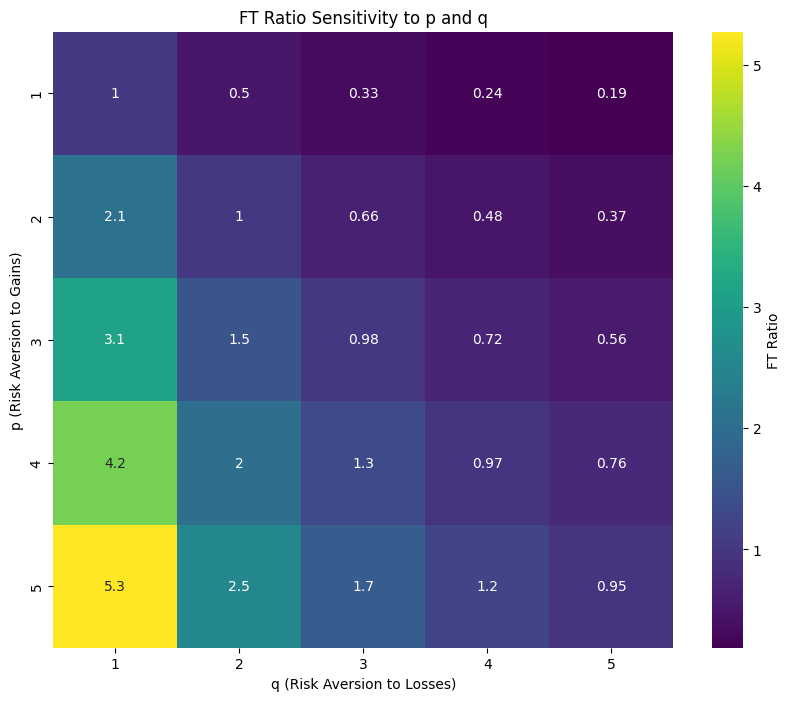

In [6]:
p_values = [1, 2, 3, 4, 5]
q_values = [1, 2, 3, 4, 5]
sensitivity_results = []

for p in p_values:
    for q in q_values:
        ft_ratio = empirical_ft_ratio(returns_aapl, eta, p, q)
        sensitivity_results.append((p, q, ft_ratio))

# Creating a DataFrame
sensitivity_df = pd.DataFrame(sensitivity_results, columns=['p', 'q', 'FT_Ratio'])

# Creating a pivot table
pivot_table = sensitivity_df.pivot(index='p', columns='q', values='FT_Ratio')

# Using seaborn to create a heatmap from the pivot table
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap='viridis', cbar_kws={'label': 'FT Ratio'})
plt.title('FT Ratio Sensitivity to p and q')
plt.xlabel('q (Risk Aversion to Losses)')
plt.ylabel('p (Risk Aversion to Gains)')
plt.show()

# **252-Day Rolling for Different p and q**

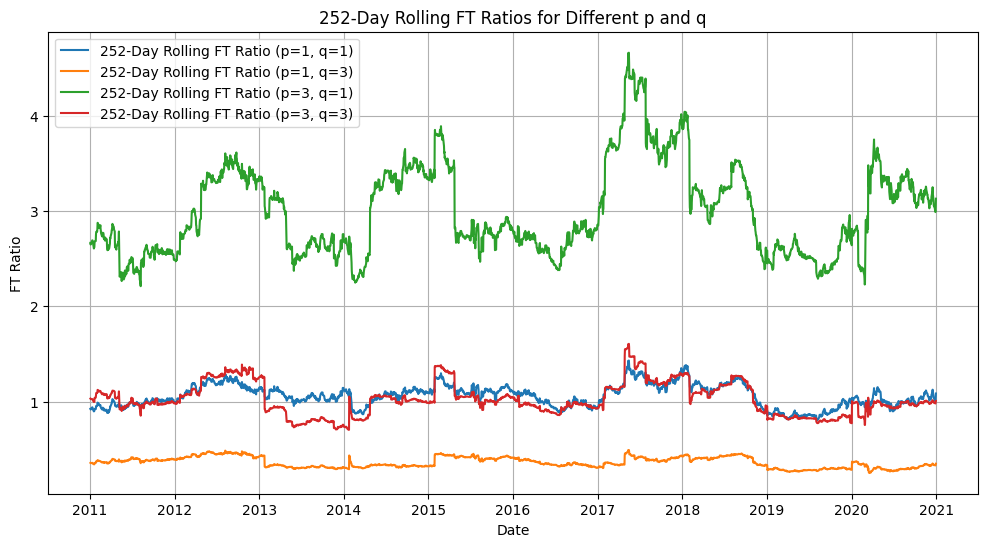

In [7]:
p_values = [1, 3]
q_values = [1, 3]
rolling_window = 252  # Define the window size

plt.figure(figsize=(12, 6))

# Calculate and plot rolling F–T Ratio for each (p, q) pair
for p in p_values:
    for q in q_values:
        rolling_ft_ratios = returns_aapl.rolling(rolling_window).apply(
            lambda x: empirical_ft_ratio(x, np.quantile(x, 0.5), p, q) if len(x) > 0 else np.nan
        )
        plt.plot(returns_aapl.index, rolling_ft_ratios, label=f'{rolling_window}-Day Rolling FT Ratio (p={p}, q={q})')

plt.title(f'{rolling_window}-Day Rolling FT Ratios for Different p and q')
plt.xlabel('Date')
plt.ylabel('FT Ratio')
plt.legend()
plt.grid(True)
plt.show()

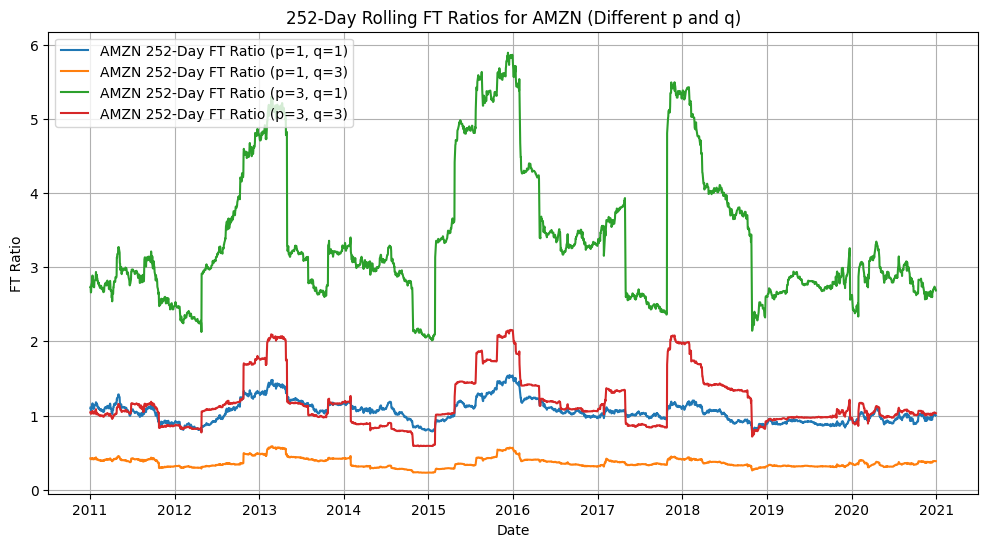

In [14]:
# Calculate and plot rolling F–T Ratio for each (p, q) pair for AMZN
plt.figure(figsize=(12, 6))
for p in p_values:
    for q in q_values:
        rolling_ft_ratios_amzn = returns_amzn.rolling(rolling_window).apply(
            lambda x: empirical_ft_ratio(x, np.quantile(x, 0.5), p, q) if len(x) > 0 else np.nan
        )
        plt.plot(returns_amzn.index, rolling_ft_ratios_amzn, label=f'AMZN {rolling_window}-Day FT Ratio (p={p}, q={q})')

plt.title(f'{rolling_window}-Day Rolling FT Ratios for AMZN (Different p and q)')
plt.xlabel('Date')
plt.ylabel('FT Ratio')
plt.legend()
plt.grid(True)
plt.show()

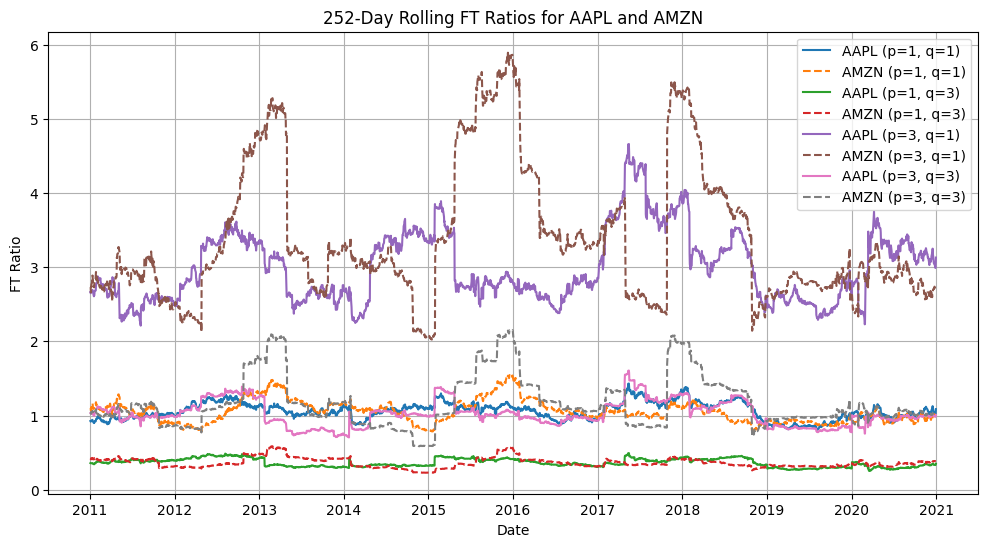

In [15]:
p_values = [1, 3]
q_values = [1, 3]
rolling_window = 252  # Define the window size

plt.figure(figsize=(12, 6))

# Loop through each combination of p and q values
for p in p_values:
    for q in q_values:
        # Calculate rolling F–T Ratio for AAPL
        rolling_ft_ratios_aapl = returns_aapl.rolling(rolling_window).apply(
            lambda x: empirical_ft_ratio(x, np.quantile(x, 0.5), p, q) if len(x) > 0 else np.nan
        )
        # Plot AAPL F–T Ratio
        plt.plot(returns_aapl.index, rolling_ft_ratios_aapl, label=f'AAPL (p={p}, q={q})')

        # Calculate rolling F–T Ratio for AMZN
        rolling_ft_ratios_amzn = returns_amzn.rolling(rolling_window).apply(
            lambda x: empirical_ft_ratio(x, np.quantile(x, 0.5), p, q) if len(x) > 0 else np.nan
        )
        # Plot AMZN F–T Ratio
        plt.plot(returns_amzn.index, rolling_ft_ratios_amzn, linestyle='--', label=f'AMZN (p={p}, q={q})')

plt.title('252-Day Rolling FT Ratios for AAPL and AMZN')
plt.xlabel('Date')
plt.ylabel('FT Ratio')
plt.legend()
plt.grid(True)
plt.show()

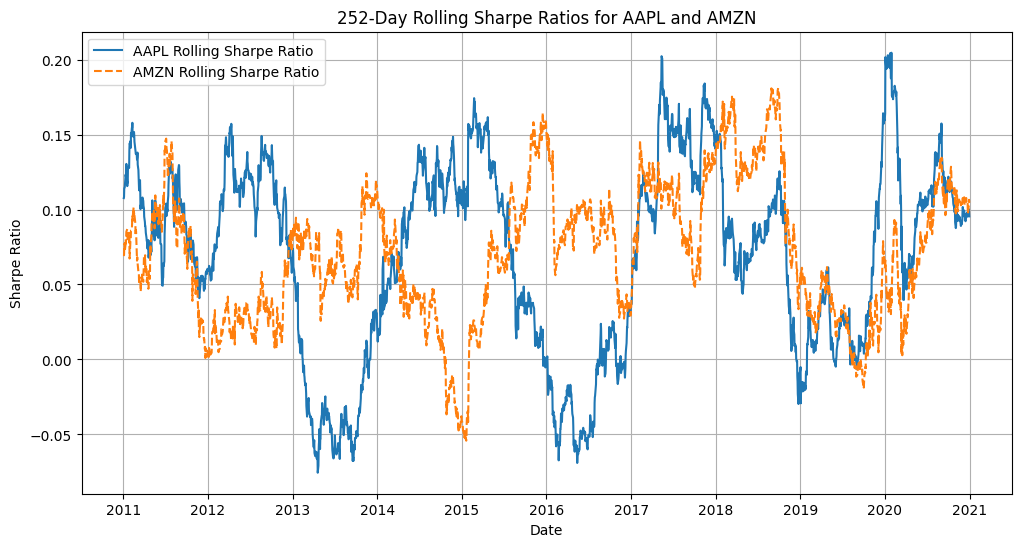

In [18]:
# Define the window for the rolling calculation
rolling_window = 252  # Using 252 trading days in a year

# Define the risk-free rate (assuming a very low risk-free rate for simplicity)
risk_free_rate = 0.01 / 252  # Daily risk-free rate if annual is 1%

# Function to calculate rolling Sharpe Ratio
def rolling_sharpe(returns):
    return (returns.rolling(window=rolling_window).mean() - risk_free_rate) / returns.rolling(window=rolling_window).std()

# Calculate rolling Sharpe Ratio for AAPL and AMZN
sharpe_aapl = rolling_sharpe(returns_aapl)
sharpe_amzn = rolling_sharpe(returns_amzn)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(sharpe_aapl.index, sharpe_aapl, label='AAPL Rolling Sharpe Ratio')
plt.plot(sharpe_amzn.index, sharpe_amzn, linestyle='--', label='AMZN Rolling Sharpe Ratio')
plt.title('252-Day Rolling Sharpe Ratios for AAPL and AMZN')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.show()


# **252-Days Rolling for Different Thresholds**

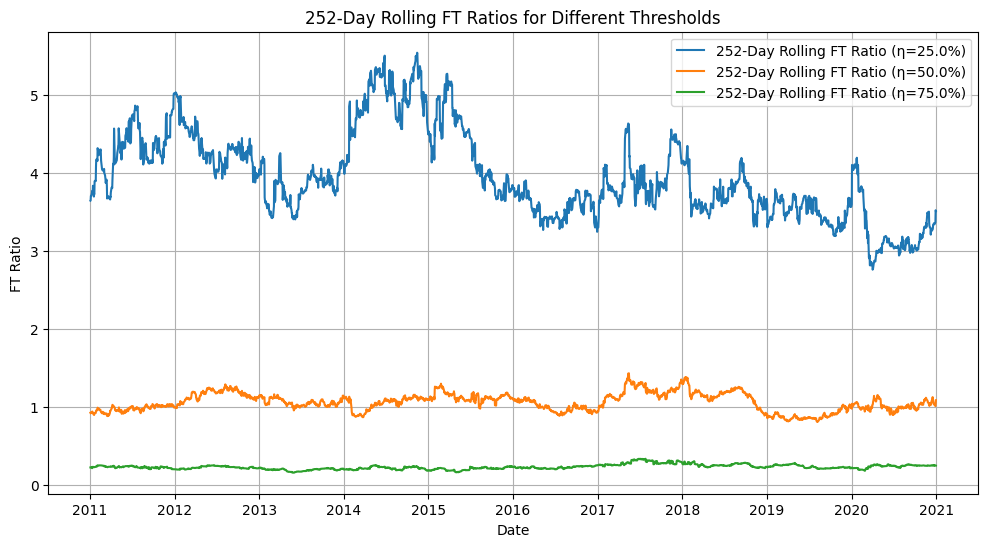

In [20]:
thresholds = [0.25, 0.5, 0.75]  # 25th, 50th, and 75th percentiles

plt.figure(figsize=(12, 6))

# Calculate and plot rolling F–T Ratio for different thresholds
for eta_quantile in thresholds:
    rolling_ft_ratios = returns_aapl.rolling(rolling_window).apply(
        lambda x: empirical_ft_ratio(x, np.quantile(x, eta_quantile), 1, 1) if len(x) >= rolling_window else np.nan
    )
    # Ensure the lengths of date indices and F-T ratios match
    plt.plot(returns_aapl.index, rolling_ft_ratios, label=f'{rolling_window}-Day Rolling FT Ratio (η={eta_quantile*100}%)')

plt.title(f'{rolling_window}-Day Rolling FT Ratios for Different Thresholds')
plt.xlabel('Date')
plt.ylabel('FT Ratio')
plt.legend()
plt.grid(True)
plt.show()

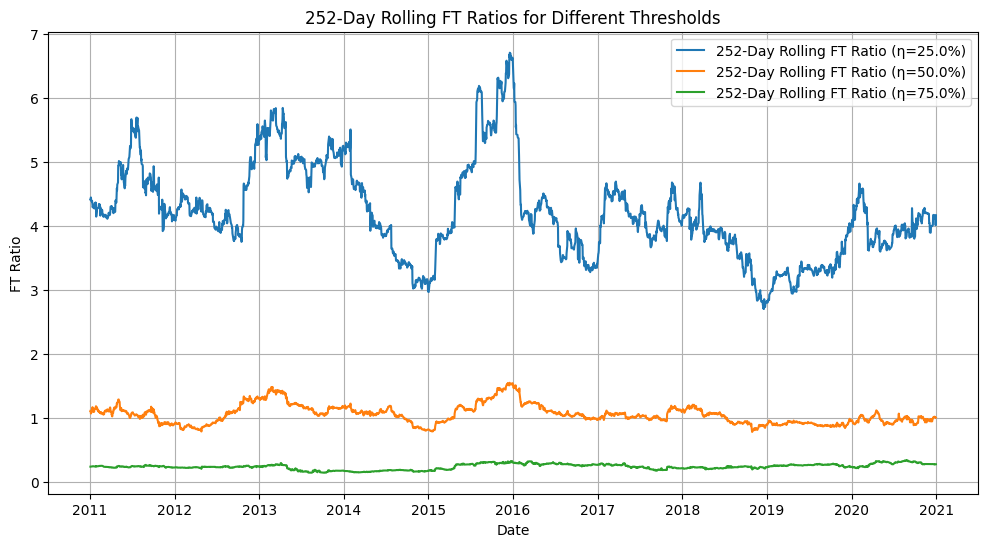

In [21]:
thresholds = [0.25, 0.5, 0.75]  # 25th, 50th, and 75th percentiles

plt.figure(figsize=(12, 6))

# Calculate and plot rolling F–T Ratio for different thresholds
for eta_quantile in thresholds:
    rolling_ft_ratios = returns_amzn.rolling(rolling_window).apply(
        lambda x: empirical_ft_ratio(x, np.quantile(x, eta_quantile), 1, 1) if len(x) >= rolling_window else np.nan
    )
    # Ensure the lengths of date indices and F-T ratios match
    plt.plot(returns_amzn.index, rolling_ft_ratios, label=f'{rolling_window}-Day Rolling FT Ratio (η={eta_quantile*100}%)')

plt.title(f'{rolling_window}-Day Rolling FT Ratios for Different Thresholds')
plt.xlabel('Date')
plt.ylabel('FT Ratio')
plt.legend()
plt.grid(True)
plt.show()